In [126]:
import Pkg; Pkg.add("Images")
import Pkg; Pkg.add("ImageMagick")

  Resolving package versions...
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/ashah20/.julia/environments/v1.5/Manifest.toml`


In [127]:
using Knet: Knet, KnetArray, deconv4, conv4, pool, mat, nll, accuracy, progress, sgd, param, param0, dropout, relu, minibatch, Data
import CUDA
using CUDA: CUDA, CuArray
using Images
using ImageMagick
using Random
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth

In [128]:
bs = 64;
resolution = 16; #16 for Baseline
decoder_res = 2
slot_size = 64;
num_slots = 1;

In [129]:
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
atype() = array_type
atype(x) = convert(atype(),x)

function load_image(filename)
    img = load(filename)
    img = imresize(img, (resolution,resolution))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
    img = img .* 2 .- 1
end

struct CLEVR
    images
    batchsize::Int
    num_instances::Int
    shuffle::Bool
    function CLEVR(datasetPaths; batchsize::Int=32, shuffle::Bool=false)
        nFullBatches, rem = divrem(size(datasetPaths)[end], batchsize)
        new(datasetPaths[1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize, shuffle)
    end
end

function length(d::CLEVR)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

function iterate(d::CLEVR, state=ifelse(d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    if length(state) > 0
        imgBatch = load_image.(d.images[state[1:(length(state) < d.batchsize ? end : d.batchsize)]])
        batch = cat(imgBatch..., dims = 4)
        state  = state[d.batchsize+1:end]
        return atype(batch), state
    end
end

iterate (generic function with 435 methods)

In [130]:
trainDataPath = "//userfiles//ashah20//datasets//tetrominoes//train//images"
files = readdir(trainDataPath);
filenames = files[endswith.(files, ".jpg")]
filenames = ["$(trainDataPath)//$(file)" for file in filenames];

clevrDataset = CLEVR(filenames, batchsize=bs, shuffle = true);

In [131]:
function mse(predictions, targets)
    N = length(targets)
    y = 1/(2*N) * sum((predictions .- targets).^2)
    return y
end

mse (generic function with 1 method)

In [175]:
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(conv4(c.w, dropout(x,c.p), padding=(2,2), stride=1) .+ c.b)
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

struct DeConv; w; b; f; p; end
(c::DeConv)(x) = c.f.(deconv4(c.w, dropout(x,c.p), padding=(1,1), stride=1) .+ c.b)
DeConv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = DeConv(param(w1,w2,cy,cx), param0(1,1,cy,1), f, pdrop)

struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mse(c(x),y)
(c::Chain)(d::CLEVR) = mean(c(x,x) for x in d)

In [133]:
hidden_dim = 32; #64 for CLEVR

slot_mlp = Chain(Dense(16*16*3, 512),
                Dense(512, 1024),
                Dense(1024, 1024),
                Dense(1024, slot_size*num_slots)) 

Chain((Dense(P(KnetArray{Float32,2}(512,768)), P(KnetArray{Float32,1}(512)), Knet.Ops20.relu, 0), Dense(P(KnetArray{Float32,2}(1024,512)), P(KnetArray{Float32,1}(1024)), Knet.Ops20.relu, 0), Dense(P(KnetArray{Float32,2}(1024,1024)), P(KnetArray{Float32,1}(1024)), Knet.Ops20.relu, 0), Dense(P(KnetArray{Float32,2}(64,1024)), P(KnetArray{Float32,1}(64)), Knet.Ops20.relu, 0)))

In [195]:
x = first(clevrDataset)
x = array_type(x)
println(typeof(x))
x_in = reshape(x, (resolution*resolution*3, bs))
println(size(x_in))

slotout = slot_mlp(x_in)
println(slot_size)
decoder_res = 2

decoder_in = array_type(ones(decoder_res, decoder_res, slot_size, bs)).*reshape(slotout,(1,1,slot_size, bs))

KnetArray{Float32,4}
(768, 64)
64


2×2×64×64 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.486155  0.486155
 0.486155  0.486155

[:, :, 2, 1] =
 0.60033  0.60033
 0.60033  0.60033

[:, :, 3, 1] =
 0.770974  0.770974
 0.770974  0.770974

...

[:, :, 62, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 63, 1] =
 0.285666  0.285666
 0.285666  0.285666

[:, :, 64, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 2] =
 0.551667  0.551667
 0.551667  0.551667

[:, :, 2, 2] =
 0.593212  0.593212
 0.593212  0.593212

[:, :, 3, 2] =
 0.581668  0.581668
 0.581668  0.581668

...

[:, :, 62, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 63, 2] =
 0.39814  0.39814
 0.39814  0.39814

[:, :, 64, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 3] =
 0.477886  0.477886
 0.477886  0.477886

[:, :, 2, 3] =
 0.353776  0.353776
 0.353776  0.353776

[:, :, 3, 3] =
 0.528003  0.528003
 0.528003  0.528003

...

[:, :, 62, 3] =
 0.0  0.0
 0.0  0.0

[:, :, 63, 3] =
 0.153225  0.153225
 0.153225  0.153225

[:, :, 64, 3] =
 0.0  0.0
 0.0  0.0

...

[:, :, 1, 62] =
 0.385491  0.385491
 0.385491  0.385491

[:

In [205]:
function outputPad(x) 
    a, b, c, d = size(x)
    paddedzeros = param0(a+2, b+2, c, d)
    paddedzeros[2:a+1, 2:b+1, :, :] .= x
    return paddedzeros
end

# struct outputPad; end
# (c::outputPad)(x) = pad(x)


outputPad (generic function with 1 method)

In [206]:
d1 = DeConv(5,5,slot_size,hidden_dim)(decoder_in)
d1 = outputPad(d1) 
d2 = DeConv(5,5,hidden_dim,hidden_dim)(d1)
d2 = outputPad(d2) 
d3 = DeConv(5,5,hidden_dim,hidden_dim)(d2)
d3 = outputPad(d3) 
d4 = DeConv(5,5,hidden_dim,3)(d3)


16×16×3×64 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0          0.000584463  0.0         …  0.0          0.0
 0.0          0.0          0.0            0.00202006   0.0
 0.000616706  9.69153f-5   0.00207035     0.0          0.0
 0.000359766  0.000960135  0.0            0.0028581    0.0
 0.00139814   0.00445976   0.0            0.000901479  0.0
 0.000860687  0.00571624   0.00846809  …  0.00435722   0.0
 0.00364801   0.00137533   0.0            0.0          0.00502418
 0.0          0.00692021   0.0104445      0.0          0.0
 0.000724802  0.00768847   0.0142291      0.0          0.0
 0.0          0.00885306   0.0055604      0.0          0.0
 0.0038112    0.0          0.0         …  0.0          0.000667782
 0.0          0.00446275   0.00581562     0.0          0.0
 0.0          0.00317651   0.00116954     0.00243172   0.000942631
 0.0          0.0          0.0            0.000750146  0.0
 0.0          0.0          0.00354151     0.00208633   0.00024948
 0.000383452  0.000227429  0.0       

In [188]:
decoder =  Chain(DeConv(5,5,slot_size,hidden_dim),
                outputPad(),
                DeConv(5,5,hidden_dim,hidden_dim),
                outputPad(),
                DeConv(5,5,hidden_dim,hidden_dim),
                outputPad(),
                DeConv(5,5,hidden_dim,3))

LoadError: MethodError: no method matching outputPad()
Closest candidates are:
  outputPad(!Matched::Any) at In[187]:1

In [207]:
mse(d4, x)

0.408775528271993

In [45]:
struct flatten1; end
(c::flatten1)(x) = permutedims(reshape(x, (resolution*resolution, hidden_dim, bs)), [2,1,3])

struct reshape1; end
(c::reshape1)(x) = permutedims(reshape(x, (resolution*resolution, hidden_dim, bs)), [2,1,3])

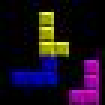

In [193]:
img = load(filenames[22])

In [ ]:
for batch in clevrDataset
    println(size(batch))
    println(typeof(batch))
    encoder(batch)
    break
end